In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
def load_data():
    '''
    This function reads the dataset file and returns a DataFrame with only the 6 required columns.

    Parameters: None

    Returns:
    1. df: Pandas DataFrame
    A Pandas DataFrame containing only 6 columns
    '''
    df = pd.read_csv('2023-02-19_21_11_28_my_iOS_device.csv') # reading the .csv file
    print(df)  # print the file object
    return df[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)',
               'accelerometerAccelerationZ(G)', 'gyroRotationX(rad/s)',
               'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)']] # returning only the specified columns

df = load_data()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   accelerometerAccelerationX(G)  3927 non-null   float64
 1   accelerometerAccelerationY(G)  3927 non-null   float64
 2   accelerometerAccelerationZ(G)  3927 non-null   float64
 3   gyroRotationX(rad/s)           3927 non-null   float64
 4   gyroRotationY(rad/s)           3927 non-null   float64
 5   gyroRotationZ(rad/s)           3927 non-null   float64
dtypes: float64(6)
memory usage: 184.2 KB
None


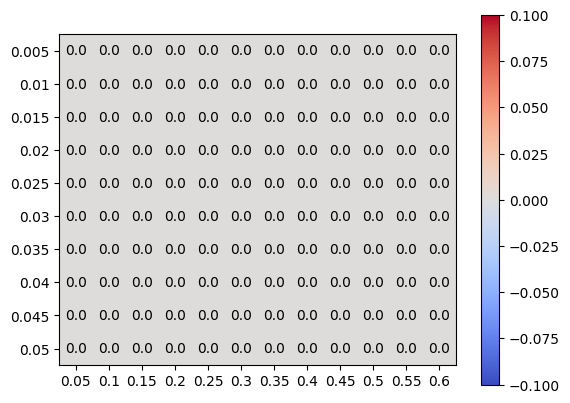

In [6]:
def compute_norm(df, selected_columns, new_column_name):
    '''
    This function returns a DataFrame with a single column containing the L2 Norm of the columns selecetd from the input DataFrame.

    Parameters:
    1. df: Pandas DataFrame of float values
    DataFrame containing the input columns
    2. selected_columns: List of Strings
    A list containing the labels (names) of the columns selected from the DataFrame
    3. new_column_name: String
    Stores the label of the column of the resultant DataFrame

    Returns:
    1. result_df: Pandas DataFrame of float values
    The resultant DataFrame containing a single column having the norm values
    '''
    result_df = pd.DataFrame(columns=[new_column_name])
    result_df[new_column_name] = np.linalg.norm(df[selected_columns].values,axis=1)
    return result_df

def zero_velocity_detection(df, acc_threshold, gyro_threshold):
    '''
    This function computes the norm values of the accelerometer and the gyroscope readings and returns a DataFrame containing 2 binary columns:
    a. For 1st column, if (accelerometer norm) + 1 < acc_threshold, then corresponding row value = 1, 0 otherwise.
    b. For 2nd column, if gyroscope norm < gyro_threshold, then corresponding row value = 1, 0 otherwise.

    Parameters:
    1. df: Pandas DataFrame of float values
    DataFrame containing the input columns
    2. acc_threshold: float
    A threshold value set for the accelerometer values
    3. gyro_threshold: float
    A threshold value set for the gyroscope values

    Returns:
    1. result_df: Pandas DataFrame of float values
    The resultant DataFrame containing the 2 binary columns
    '''
    result_df = pd.DataFrame(columns=['accelerometer ZVD', 'gyroscope ZVD'])
    result_df['accelerometer ZVD'] = compute_norm(df, ['accelerometerAccelerationX(G)', # initializing result column 1
                                                      'accelerometerAccelerationY(G)',
                                                      'accelerometerAccelerationZ(G)'], 'accelerometer ZVD')
    result_df['gyroscope ZVD'] = compute_norm(df, ['gyroRotationX(rad/s)', # initializing result column 2
                                                  'gyroRotationY(rad/s)',
                                                  'gyroRotationZ(rad/s)'], 'gyroscope ZVD')
    result_df[result_df['accelerometer ZVD']-1 < acc_threshold] = 1.0 # changing values according to the given question
    result_df[result_df['accelerometer ZVD']-1 >= acc_threshold] = 0.0
    result_df[result_df['gyroscope ZVD'] < gyro_threshold] = 1.0
    result_df[result_df['gyroscope ZVD'] >= gyro_threshold] = 0.0
    return result_df

def make_correlation_matrix_from(df, cols):
    '''
    This function returns the correlation matrix of the 2 input columns, without using any of the numpy or pandas functions or variables.

    Parameters:
    1. df: Pandas DataFrame of float values
    DataFrame containing the input columns
    2. cols: List of Strings
    A list containing the labels (names) of the columns selected from the DataFrame, length is assumed to be 2

    Returns:
    1. correlation_matrix: 2D Numpy Array of float values
    A numpy array which represents the correlation matrix of the 2 input columns
    '''
    correlation_matrix = np.eye(2)
    x = np.array(df[cols[0]]) # initializing the variable arrays
    y = np.array(df[cols[1]])
    x_mean = sum(x)/len(x) # calculating the mean values
    y_mean = sum(y)/len(y)
    xy_sum = sum(x*y) + x_mean*y_mean*len(x) - sum(x*y_mean) - sum(y*x_mean) # sum(xi-x_mean * yi-y_mean) after expanding the formula
    x_sq_sum = sum(x**2) + x_mean**2*len(x) - 2*x_mean*sum(x) # sum(xi-x)^2 after expanding the formula
    y_sq_sum = sum(y**2) + y_mean**2*len(y) - 2*y_mean*sum(y) # sum(yi-y)^2 after expanding the formula
    den = np.sqrt(x_sq_sum * y_sq_sum)
    if den == 0: correlation = 0 # correleration = 0 for undefined or constant variables
    else: correlation = xy_sum/den
    correlation_matrix[0, 1], correlation_matrix[1, 0] = correlation, correlation
    return correlation_matrix

def compute_correlations(df, acc_thresholds, gyro_thresholds):
    '''
    This function computes and returns a matrix of correlation coefficients of the 2 ZVD columns obtained by the combination of different threshold values given in the 2 input arrays

    Parameters:
    1. df: Pandas DataFrame of float values
    DataFrame containing the input columns
    2. acc_thresholds: 1D Numpy Array of float values
    A set of input threshold values set for the accelerometer values
    3. gyro_thresholds: 1D Numpy Array of float values
    A set of input threshold values set for the gyroscope values

    Returns:
    1. results_matrix: 2D Numpy Array of float values
    A matrix containing the different correlation coefficients
    '''
    results_matrix = np.ones((len(acc_thresholds), len(gyro_thresholds))) # initializing the result matrix with ones
    for n in range(len(acc_thresholds)):
      for m in range(len(gyro_thresholds)):
        zvds = zero_velocity_detection(df, acc_thresholds[n], gyro_thresholds[m]) # using all the possible combinations of both kinds of thresholds
        results_matrix[n][m] = make_correlation_matrix_from(zvds, list(zvds.columns))[0, 1] # storing the correlation values
    return results_matrix

def plot_corr(correlation_values, gyro_thresholds, acc_thresholds):
    '''
    This function plots a Heatmap of the correlation matrix according to the input array of accelerometer and gyroscope thresholds

    Parameters:
    1. correlation_values: 2D Numpy Array of float values
    A matrix containing the different correlation coefficients
    2. gyro_thresholds: 1D Numpy Array of float values
    A set of input threshold values set for the gyroscope values
    3. acc_thresholds: 1D Numpy Array of float values
    A set of input threshold values set for the accelerometer values

    Returns: None
    '''
    fig, ax = plt.subplots() # creating a figure and an axis
    cax = ax.matshow(correlation_values, cmap='coolwarm') # creting a heatmap of the correlation matrix
    for i in range(len(acc_thresholds)): # looping over the data dimensions and creating text annotations
      for j in range(len(gyro_thresholds)):
        text = ax.text(j, i, correlation_values[i, j], ha='center', va='center', color='black')
    ax.set_xticks(np.arange(len(gyro_thresholds))) # setting axis labels using threshold values
    ax.set_yticks(np.arange(len(acc_thresholds)))
    ax.set_xticklabels(gyro_thresholds) # setting and displying the labels of both the axes
    ax.set_yticklabels(acc_thresholds)
    ax.xaxis.set_ticks_position('bottom') # adjusting the positions of both the axes labels
    ax.yaxis.set_ticks_position('left')
    fig.colorbar(cax) # displaying the colour bar
    plt.show()

df = load_data()
acc_thresholds = np.round(np.linspace(5e-3,5e-2,10),3)
gyro_thresholds = np.round(np.linspace(0.05,0.6,12),2)
correlation_values = compute_correlations(df, acc_thresholds, gyro_thresholds)
plot_corr(correlation_values, gyro_thresholds, acc_thresholds)